In [1]:
!pip install beautifulsoup4


In [2]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np

Получим датасет

In [162]:
df = pd.read_csv("ryazan_dump.csv")

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3242 non-null   int64 
 1   title        3242 non-null   object
 2   date         3242 non-null   object
 3   place        3242 non-null   object
 4   online_link  3242 non-null   object
 5   category     3242 non-null   object
 6   rank         3242 non-null   object
 7   name         3242 non-null   object
 8   club         3242 non-null   object
 9   points       3242 non-null   object
dtypes: int64(1), object(9)
memory usage: 253.4+ KB


In [164]:
df.sort_values(by='points', ascending=False).head()

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points
2591,110,"Первенство, посвящённое «Дню защиты детей»",22.05.2024,Рязань,https://skating-vision.online/events/2324/ryaz...,"2-й спoртивный разряд, дeвушки",WD,Анастасия КУЛЕШОВА,"Рязань, ГАУ РО «ХК «Рязань- ВДВ»",
3239,118,Областные соревнования «Звёздный лёд»,18.03.2025,Рязань,https://skating-vision.online/events/2425/ryaz...,"KMC, дeвушки",DSQ,Таисия МАРТЫНОВА,"Москва, АНО ДО «СШ «АФК «Наши Надежды»",
3101,178,Февральский лед 2025,22.02.2025,Рязань,https://result.fspnz.ru/rzn_02_25/CAT015RS.HTM,"2 спoртивный рaзряд - Дeвочки, Девушки",WD,Ульяна ФРОЛОВА,"Рязань, ХК ""Рязань-ВДВ""",
856,146,Первенство Рязанской области (финал),09.12.2021,Рязань,https://skating-vision.online/events/2122/ryaz...,"1-й спoртивный разряд, дeвушки",WD,Софья САВИНА,"Рязань, ГАУ РО «СШ ДС «Олимпийский»",
990,125,Областные соревнования «Звёздный лёд»,17.03.2022,Рязань,https://skating-vision.online/events/2122/ryaz...,"3-й спoртивный разряд, дeвочки",FNR,Варвара РОДИОНОВА,"Рязань, ГАУ РО «СШ ДС «Олимпийский»",


In [165]:
# Удалим строки без результата
df = df.drop(df[df['rank'].isin(['WD', 'FNR', 'DSQ', '0'])].index)

In [166]:
# Приведем типы данных
df['rank'] = df['rank'].astype('int64')
df['points'] = df['points'].astype('float')
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [167]:
# Добавим год
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = df['date'].apply(lambda x: f"{x.year-2001}{x.year-2000}" if x.month < 8 else f"{x.year-2000}{x.year-1999}")

In [168]:
def replace_duplicates(df, keyword, name, field='club'):
    uniquenames = [ s for s in df[field].unique() if keyword.findall(str(s).lower()) ]
    return df[field].replace(uniquenames, name)

In [169]:
def get_regex_cat(num, cat, gender):
    return re.compile((r"(" + num + ")(?s:.*?)(" + cat + ")(?s:.*?)(" + gender + ")").lower())

In [170]:
def get_regex_club(city, club):
    return re.compile((r"(" + club + ")(?s:.*?)(" + city + ")|(" + city + ")(?s:.*?)(" + club + ")").lower())

In [171]:
df.club.unique()

array(['Рязань, ГАУ РО «СШ ДС «Олимпийский»',
       'Московская область, Ступино, СШОР им. В.М. Боброва',
       'Калуга, МБУ СШ «Космос»',
       'Пензенская область, Заречный, МАУ СКК «Союз»', 'Пенза, МБУ СШ №1',
       'Московская область, Люберцы, МУ КСШОР г.о. Люберцы',
       'Саратов, ГБУСО «СШОР «Надежда Губернии»',
       'Рязань, ГАУ РО «СШ «Айсберг»', 'Тула, ОКСШОР',
       'Московская область, Коломна, СШОР «Комета»',
       'Московская область, Раменское, СШ «Раменское»',
       'Саранск, «СДЮСШОРФК РМ»',
       'Самарская область, Тольятти, ГАУ «СШОР №1»',
       'Московская область, Лобня, СКФК «Дети - наше будущее»',
       'Самарская область, Тольятти, МБУ СШОР №13 «Волгарь»',
       'Тверская область, Конаково, МБУ «СШ «Конаковский лёд»',
       'Владимир, АНО СК ФК «Лига чемпионов»',
       'Москва, Академия фигурного катания «Ангелы Плющенко»',
       'Липецкая область, Усмань, МАУ ДО ООЦ «Ледовый дворец»',
       'Москва, АНО СК «Кристалл»', 'Иваново, РОО ФФКК ИО'

In [175]:
sorted(df['category'].unique())

['1-й спортивный разряд, девочки',
 '1-й спортивный разряд, мальчики',
 '1-й юношеский разряд, девочки',
 '1-й юношеский разряд, мальчики',
 '2-й спортивный разряд, девочки',
 '2-й спортивный разряд, мальчики',
 '2-й юношеский разряд, девочки',
 '2-й юношеский разряд, мальчики',
 '3-й спортивный разряд, девочки',
 '3-й спортивный разряд, мальчики',
 '3-й юношеский разряд, девочки',
 '3-й юношеский разряд, мальчики',
 'KMC, дeвушки',
 'KMC, юнoши',
 '«ДЕБЮT», дeвочки',
 '«ДЕБЮT», мaльчики',
 '«НОВИЧOK», дeвочки',
 '«НОВИЧOK», мaльчики',
 '«ПЕРВЫE ШАГИ», дeвочки',
 '«ПЕРВЫE ШАГИ», мaльчики',
 'Дeбют - Девочки (2018 гр и ст)',
 'Дeбют - Девочки (2019 гр и мл)',
 'Дeбют - Мaльчики',
 'Юный фигурист, девочки',
 'Юный фигурист, мальчики']

In [190]:
[ s for s in df.club.unique() if get_regex_club('Рязань', '').findall(str(s).lower()) ]

['Рязань, ГАУ РО «ХК «Рязань-ВДВ»', 'Рязань, ГАУ ДО РО «СШ «Айсберг»']

In [174]:
df['club'] = replace_duplicates(df, get_regex_club('Рязань', 'ВДВ'), 'Рязань, ГАУ РО «ХК «Рязань-ВДВ»')
df['club'] = replace_duplicates(df, get_regex_club('Рязань', 'Олимпийский'), 'Рязань, ГАУ РО «ХК «Рязань-ВДВ»')
df['club'] = replace_duplicates(df, get_regex_club('Рязань', 'Айсберг'), 'Рязань, ГАУ ДО РО «СШ «Айсберг»')

df['category'] = replace_duplicates(df, get_regex_cat("«ПЕРВЫЕ ШAГИ»", "дeвочки", ""), '«ПЕРВЫE ШАГИ», дeвочки', 'category')
df['category'] = replace_duplicates(df, get_regex_cat("«ПЕРВЫЕ ШAГИ»", "мaльчики", ""), '«ПЕРВЫE ШАГИ», мaльчики', 'category')
df['category'] = replace_duplicates(df, get_regex_cat("«НОВИЧОK»", "мaльчики", ""), '«НОВИЧOK», мaльчики', 'category')

df['category'] = replace_duplicates(df, get_regex_cat("KMC", "юни", ""), "KMC, дeвушки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("KМС", "юноши", ""), "KMC, юнoши", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "юн", "м"), "3-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "3", "юн"), "3-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "юн", "чк"), "3-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "3", "юн"), "3-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat('3', 'юн', 'уш'), "3-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "юн", "м"), "2-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "2", "юн"), "2-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "юн", "чк"), "2-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat('2', 'юн', 'уш'), "2-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "2", "юн"), "2-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "м"), "1-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "1", "юн"), "1-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "чк"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "1", "юн"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "шк"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "м"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "ю"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "3", "вн"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "3", "вн"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "чк"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "шк"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "3", "вн"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "3", "вн"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "м"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "ю"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "2", "вн"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "2", "вн"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "чк"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "шк"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "2", "вн"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "2", "вн"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "м"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "ю"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "1", "вн"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "1", "вн"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "чк"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "шк"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "1", "вн"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "1", "вн"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("Юны", "", "д"), "Юный фигурист, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("Юны", "", "м"), "Юный фигурист, мальчики", 'category')

In [176]:
year = 2024

In [177]:
def get_top_df(df, column, qty):
    df1 = df['club'].value_counts()
    others = df1[qty:].sum()
    df1 = df1[:qty]
    df1['Остальные'] = others
    return df1

In [178]:
def pie_of_winners(year, rank, limit):
    get_top_df(df[(df['year'] == year) & (df['rank'] <= rank)], 'club', limit).plot.pie(
        autopct='%1.f%%', 
        legend=False,
        wedgeprops = {"edgecolor" : "white", 
                      'linewidth': 2,
                      'antialiased': True});
    plt.title(f'Доля победителей в {year} году', fontsize=16)
    plt.xlabel('', fontsize=18)
    plt.ylabel('', fontsize=18)

In [179]:
def participants_for_club_in_year(year, club, limit, plot=True, sort_col='title'):
    data = df[(df['year'] == year) & (df['club'] == club)].groupby('name').count().sort_values(
        by=sort_col, ascending=True).head(limit)['title']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        ax.set_yticks(major_ticks)
        plt.title(club, fontsize=32)
        plt.xlabel('Спортсмен', fontsize=16)
        plt.ylabel(f'Количество участий в {year} году', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

In [180]:
def participants_for_club_in_season(season, club, limit, plot=True, sort_col='title'):
    data = df[(df['season'] == season) & (df['club'] == club)].groupby('name').count().sort_values(
        by=sort_col, ascending=(sort_col == 'name')).head(limit)['title']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        ax.set_yticks(major_ticks)
        plt.title(club, fontsize=32)
        plt.xlabel('Спортсмен', fontsize=16)
        plt.ylabel(f'Количество участий в сезоне {season}', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

In [181]:
def plot_clubs_in_year(year, limit):
    df[df['year'] == year].groupby('club').count().sort_values(by='title', ascending=False)['title'].head(limit).plot(
        kind='bar', figsize=(20, 5), grid=True
    )
    plt.title(f'Распределение количества участий школ в {year} году', fontsize=32)
    plt.xlabel('Школа', fontsize=18)
    plt.ylabel('Количество участий', fontsize=18)
    plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

In [182]:
def sportsmens_of_clubs_in_year(year, limit, plot=True):
    tg_df = df[df['year'] == year].groupby(['club', 'name']).count().groupby('club').count().sort_values(
        by='title', ascending=False)['title'].head(limit)
    if plot:
        tg_df.plot(
            kind='bar', figsize=(25, 8), grid=True
        )
        plt.title(f'Количество спортсменов, участвовавших в официальных соревнованиях за {year} год', fontsize=32)
        plt.xlabel('Школа', fontsize=18)
        plt.ylabel('Количество спортсменов', fontsize=18)
        plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');
    else:
        return tg_df

In [183]:
def winners_of_club(year, club):
    if type(year) == int:
        year_list = [year]
    else:
        year_list = year[:]
    return df[(df['year'].isin(year_list)) & (df['rank'] <= 3) & (df['club'] == club)]

In [184]:
def get_df_of_club_in_year(club, year):
    return df[(df['year'] == year) & (df['club'] == club)]

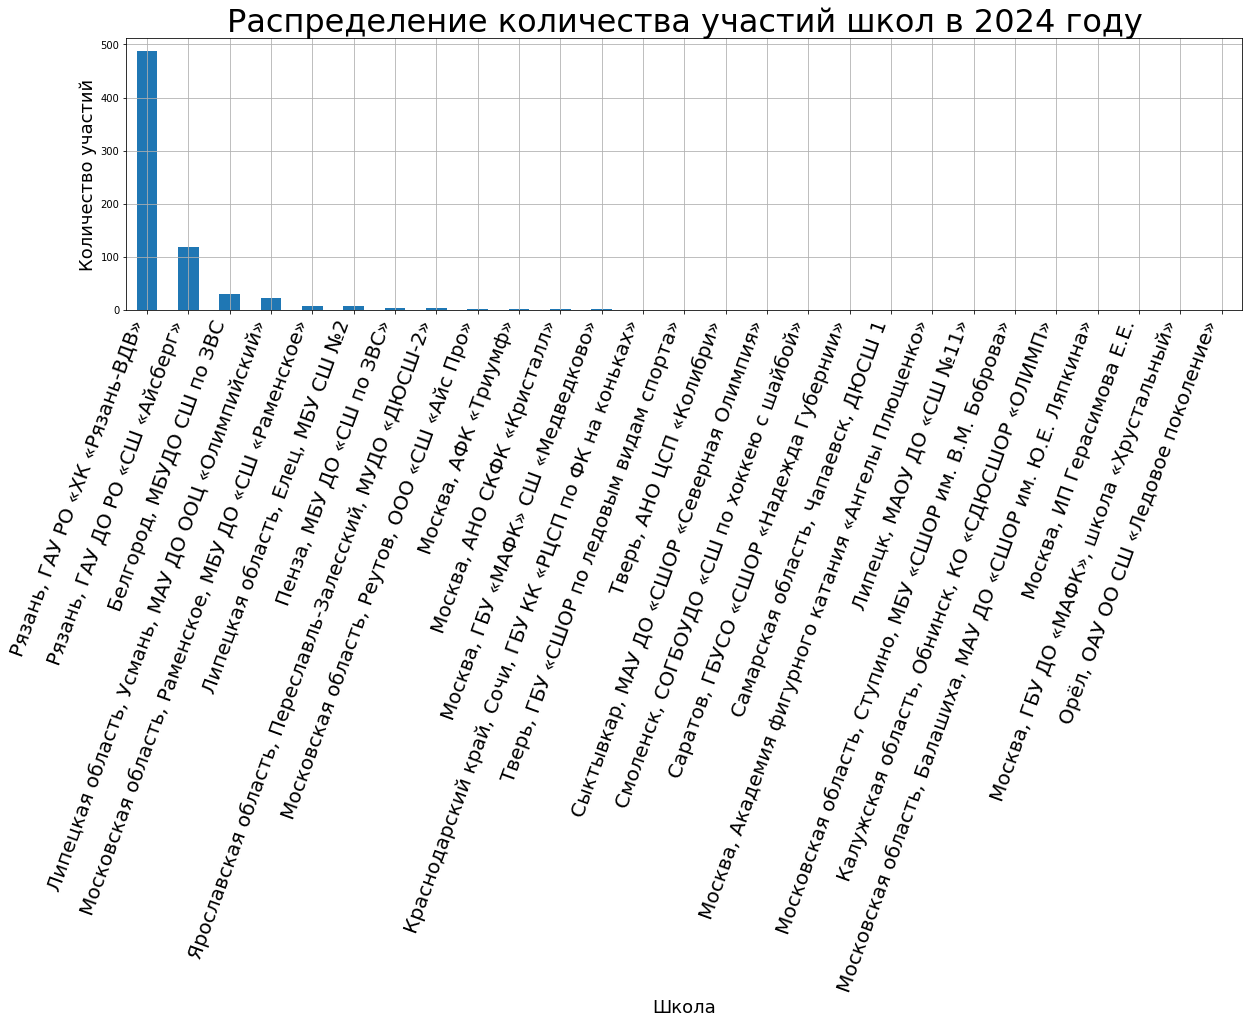

In [185]:
plot_clubs_in_year(2024, 40)

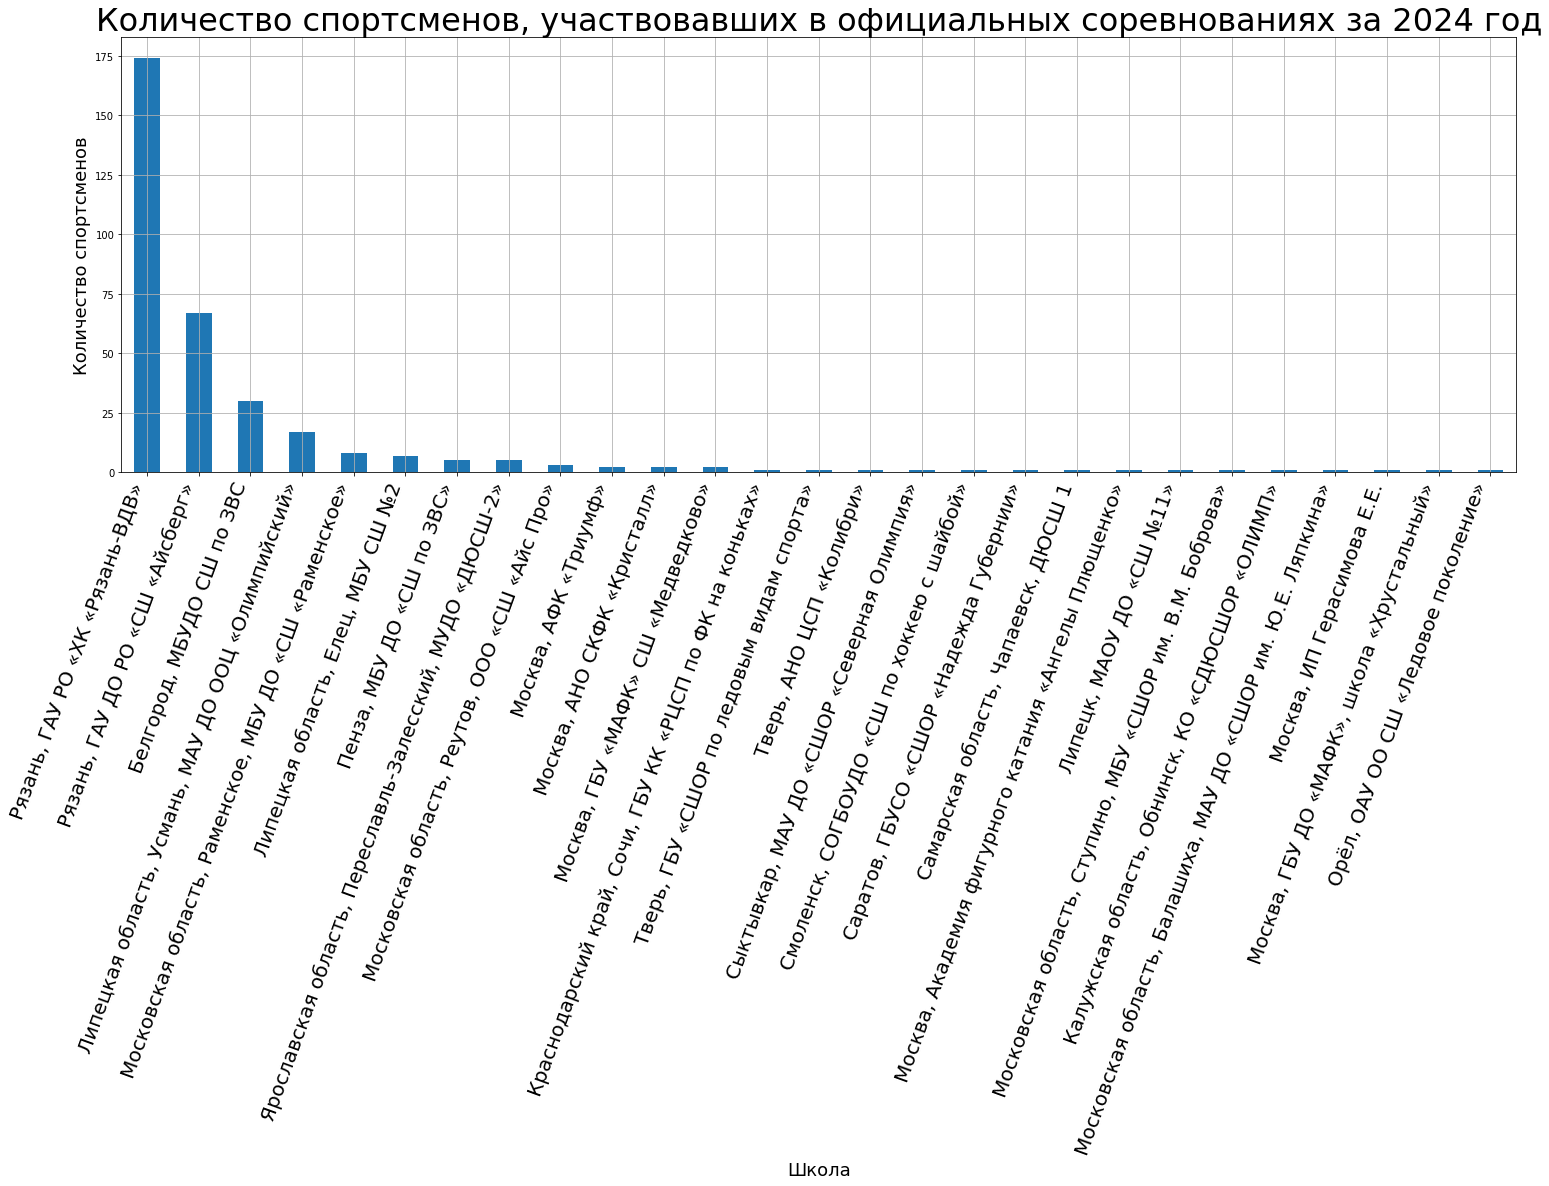

In [186]:
sportsmens_of_clubs_in_year(2024, 40, plot=True)

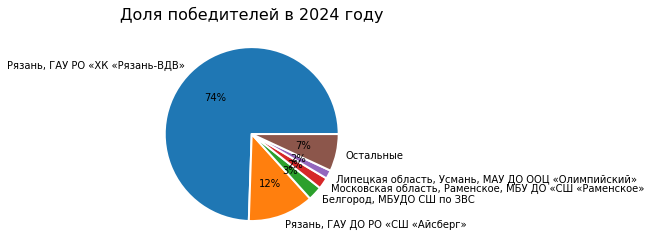

In [187]:
pie_of_winners(2024, 3, 5)

In [93]:
vdv = 'Рязань, ГАУ РО «ХК «Рязань-ВДВ»'

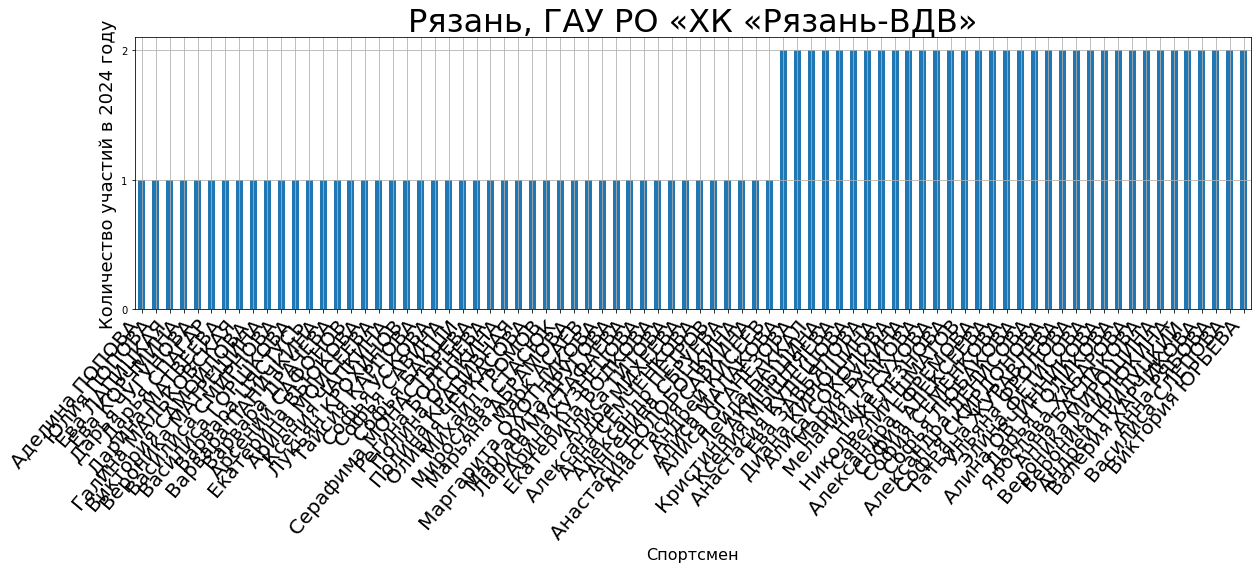

In [94]:
participants_for_club_in_year(2024, vdv, 80)

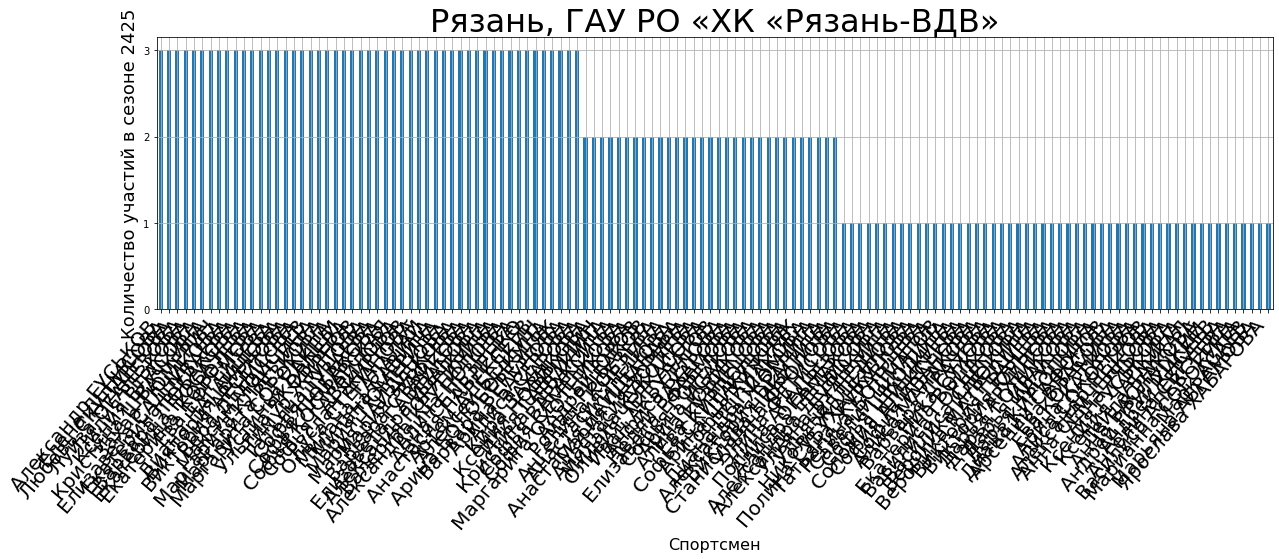

In [95]:
participants_for_club_in_season("2425", vdv, 150)

In [96]:
get_df_of_club_in_year(vdv, 2025).tail(30)

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year,month,season
2997,74,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",3,Екатерина НОСАЧЕВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",37.64,2025,3,2425
3000,77,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",6,Арина БОЛОБОНКИНА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",34.77,2025,3,2425
3001,78,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",7,Екатерина ШУВАЕВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",34.54,2025,3,2425
3002,79,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",8,Варвара ЛЮБАКОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",34.41,2025,3,2425
3003,80,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",9,Маргарита ОХОТНИКОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",33.74,2025,3,2425
3004,81,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",10,Анастасия НЕЛИНА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",32.08,2025,3,2425
3006,83,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, девочки",12,Софья ЛЮБАКОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",31.58,2025,3,2425
3009,86,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, мальчики",1,Максим МОИСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",28.30,2025,3,2425
3010,87,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"3-й спортивный разряд, мальчики",2,Алексей БЕЛКИН,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",28.28,2025,3,2425
3011,88,Областные соревнования «Звёздный лёд»,2025-03-18,Рязань,https://skating-vision.online/events/2425/ryaz...,"2-й спортивный разряд, девочки",1,Варвара БЕРЕЗНЯК,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",101.95,2025,3,2425


In [97]:
winners_of_club([2025], vdv).name.unique()

array(['Ольга СТЕПАНОВА', 'Лилия РЕЗКОВА', 'Александра ИВАНОВА',
       'Артем АЛЕКСЕЕВ', 'Александр ГУСЬКОВ', 'Устинья БАКШИ',
       'Софья ВАРАКСИНА', 'Руслан ЖИРНОВ', 'Захар ТЮМЕРИН',
       'Алиса СЕРОВА', 'Ульяна ГНЕДИНА', 'Екатерина НОСАЧЕВА',
       'Максим МОИСЕЕВ', 'Алексей БЕЛКИН', 'Варвара БЕРЕЗНЯК',
       'Анастасия ПАВЛЕНКО', 'Диана ЦЫПЛАКОВА', 'Екатерина КОРОЛЕВА',
       'Алина ПОПОВА', 'Иван АКБУЛАТОВ', 'Анна РЯБОВА', 'Диана НАГАЙЦЕВА',
       'Любовь СКУДАРНОВА', 'Роман РЫБАКОВ', 'Тимур ЖИРНОВ'], dtype=object)

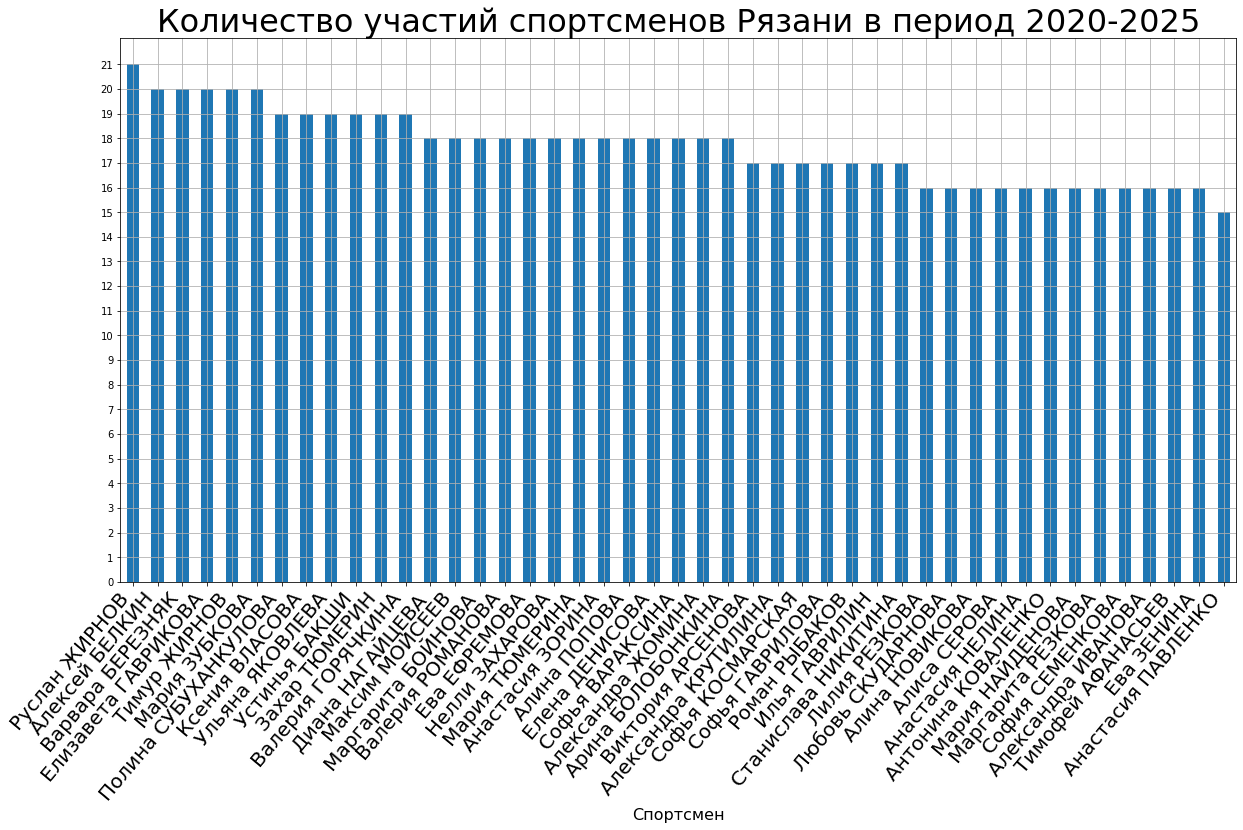

In [98]:
data = df.groupby('name').count().sort_values(
    by='title', ascending=False).head(45)['title']
ax = data.plot(
    kind='bar', figsize=(20, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 1, 1)
ax.set_yticks(major_ticks)
plt.title("Количество участий спортсменов Рязани в период 2020-2025", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [135]:
category_names = df['category'].unique()

In [191]:
df[df['category'] == 'Юный фигурист, мальчики']

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year,month,season
61,61,"ПЕРВЕНСТВО РЯЗАНСКОЙ ОБЛАСТИ, I этап",2021-01-20,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",1,Алексей БЕЛКИН,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",9.59,2021,1,2021
62,62,"ПЕРВЕНСТВО РЯЗАНСКОЙ ОБЛАСТИ, I этап",2021-01-20,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",2,Станислав АЛЕКСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",9.27,2021,1,2021
63,63,"ПЕРВЕНСТВО РЯЗАНСКОЙ ОБЛАСТИ, I этап",2021-01-20,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",3,Максим МОИСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",8.95,2021,1,2021
64,64,"ПЕРВЕНСТВО РЯЗАНСКОЙ ОБЛАСТИ, I этап",2021-01-20,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",4,Михаил ГРОМОВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",7.53,2021,1,2021
65,65,"ПЕРВЕНСТВО РЯЗАНСКОЙ ОБЛАСТИ, I этап",2021-01-20,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",5,Руслан ЖИРНОВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",5.70,2021,1,2021
198,32,Областные соревнования «Звёздный лёд»,2021-03-03,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",1,Станислав АЛЕКСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",9.52,2021,3,2021
199,33,Областные соревнования «Звёздный лёд»,2021-03-03,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",2,Захар ТЮМЕРИН,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",7.70,2021,3,2021
200,34,Областные соревнования «Звёздный лёд»,2021-03-03,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",3,Максим МОИСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",7.57,2021,3,2021
201,35,Областные соревнования «Звёздный лёд»,2021-03-03,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",4,Руслан ЖИРНОВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",7.37,2021,3,2021
202,36,Областные соревнования «Звёздный лёд»,2021-03-03,Рязань,https://skating-vision.online/events/2021/ryaz...,"Юный фигурист, мальчики",5,Михаил ГРОМОВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",5.97,2021,3,2021


In [193]:
df[df['year'] == 2025].sort_values(by="points").groupby("category").last()[['date', 'name', 'club', 'points']]

,date,name,club,points
category,,,,
"1-й спортивный разряд, девочки",2025-03-18,Диана ЦЫПЛАКОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",110.21
"1-й спортивный разряд, мальчики",2025-02-22,Тимофей АФАНАСЬЕВ,"Рязань, ГАУ ДО РО «СШ «Айсберг»",107.74
"1-й юношеский разряд, девочки",2025-03-18,Устинья БАКШИ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",43.02
"1-й юношеский разряд, мальчики",2025-03-18,Руслан ЖИРНОВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",35.22
"2-й спортивный разряд, девочки",2025-03-18,Варвара БЕРЕЗНЯК,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",101.95
"2-й юношеский разряд, девочки",2025-03-18,Лилия РЕЗКОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",28.15
"2-й юношеский разряд, мальчики",2025-02-22,Артем АЛЕКСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",27.41
"3-й спортивный разряд, девочки",2025-03-18,Алиса СЕРОВА,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",39.99
"3-й спортивный разряд, мальчики",2025-02-22,Максим МОИСЕЕВ,"Рязань, ГАУ РО «ХК «Рязань-ВДВ»",29.14


In [195]:
df[df['category'].isin(category_names)&(df['year']==2025)].groupby("category").count()['title']

category
1-й спортивный разряд, девочки     18
1-й спортивный разряд, мальчики     5
1-й юношеский разряд, девочки      21
1-й юношеский разряд, мальчики      4
2-й спортивный разряд, девочки     33
2-й юношеский разряд, девочки      40
2-й юношеский разряд, мальчики      3
3-й спортивный разряд, девочки     29
3-й спортивный разряд, мальчики     4
3-й юношеский разряд, девочки      88
3-й юношеский разряд, мальчики      2
KMC, дeвушки                        8
KMC, юнoши                          2
Юный фигурист, девочки             35
Юный фигурист, мальчики             1
Name: title, dtype: int64

In [201]:
pivot_df = pd.pivot_table(df, values='title', index='club', columns='season', aggfunc='count')

In [203]:
pivot_df.loc[vdv]

season
2021    480.0
2122    561.0
2223    475.0
2324    461.0
2425    370.0
Name: Рязань, ГАУ РО «ХК «Рязань-ВДВ», dtype: float64

In [209]:
pd.pivot_table(df[df.club=='Рязань, ГАУ РО «ХК «Рязань-ВДВ»'], values='title', index='name', columns='season', aggfunc='count').to_csv("ryazan_dump.csv", decimal=",")